In [2]:
import os
import plaidml.keras
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import sys
import plaidml.keras
from os import listdir
from numpy import asarray
from numpy import save
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from numpy import load

In [4]:
import numpy as np
import glob

#### Load the overloaded data

In [22]:
image_over_train = load("overloaded_train_images.npy")
label_over_train = load("overloaded_train_labeles.npy")

In [23]:
image_over_test = load("test_images.npy")
label_over_test = load("test_labeles.npy")

#### Check if it is oversampled

In [24]:
oversampled_train_df = pd.DataFrame(label_over_train)
oversampled_train_df.rename(columns={0: "has_oilpalm"}, inplace=True)

In [25]:
oversampled_train_df.head()

,has_oilpalm
0,0
1,0
2,1
3,0
4,1


In [26]:
df_class1 = oversampled_train_df[oversampled_train_df['has_oilpalm'] == 1]
df_class0 = oversampled_train_df[oversampled_train_df['has_oilpalm'] == 0]

In [27]:
df_plot = pd.concat([df_class0, df_class1], axis=0)

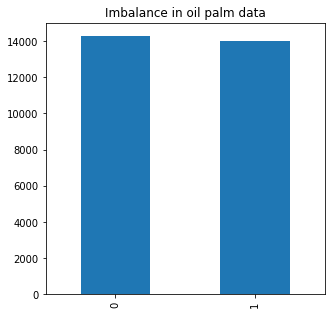

In [28]:
fig = plt.figure(figsize=(5,5))
df_plot['has_oilpalm'].value_counts().plot(kind='bar', title = 'Number of Images')
plt.title("Imbalance in oil palm data")
plt.show()

### Modeling

In [29]:
import keras
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Conv2D, Conv1D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

#### Visualize Model Training History

In [30]:
def plothistory(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

#### Utitlity function that gives me classification relevant metrics

In [31]:
def GetMetrics(model, x_test, y_test, name):
    
    prediction = model.predict(x_test)
    y_pred = [1 if prediction[i][0]> .5 else 0 for i in range(len(prediction))]
    
    metrics = pd.DataFrame(columns = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC'])
    metrics['Accuracy'] = [accuracy_score(y_test, y_pred)]
    metrics['Precision'] = [precision_score(y_test, y_pred)]
    metrics['Recall'] = [recall_score(y_test, y_pred)]
    metrics['F1'] = [f1_score(y_test, y_pred)]
    metrics['ROC'] = [roc_auc_score(y_test, y_pred)]
    
    false_positive_rate, true_positive_rate, threshold1 = roc_curve(y_test, y_pred)
    
    fig = plt.figure(figsize=(5,5))
    plt.title('ROC Curve for ' + name)
    plt.plot(false_positive_rate, true_positive_rate)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    stats = metrics.sort_values('Accuracy', ascending = False)
    return stats

In [32]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model

In [33]:
restnet = ResNet50(include_top = False, weights='imagenet', input_shape=(200, 200, 3))
output = restnet.layers[-1].output
output = Flatten()(output)

INFO:plaidml:Opening device "metal_amd_radeon_pro_570x.0"
/opt/anaconda3/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [34]:
restnet = Model(restnet.input, output=output)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(input_1 Pl..., outputs=BatchFlatt...)`
  """Entry point for launching an IPython kernel.


In [35]:
for layer in restnet.layers:
    layer.trainable = False

In [36]:
restnet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 100, 100, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [37]:
def getResNet():
    model = Sequential()
    model.add(restnet)
    model.add(Dense(512, activation='relu', input_dim = (200, 200, 3)))
    model.add(Dropout(0.25))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [38]:
resnet = getResNet()
resnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 100352)            23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               51380736  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 75,231,617
Trainable params: 51,643,905
Non-trainable params: 23,587,712
_______________________________________________________

In [40]:
history = resnet.fit(image_over_train, label_over_train, validation_data=(image_over_test, label_over_test), epochs=10, batch_size = 128)

Train on 28300 samples, validate on 4356 samples
Epoch 1/10
28300/28300 [==============================] - 1735s 61ms/step - loss: 0.4560 - acc: 0.9687 - val_loss: 5.9914 - val_acc: 0.6173
Epoch 2/10
28300/28300 [==============================] - 2091s 74ms/step - loss: 0.3259 - acc: 0.9794 - val_loss: 1.7821 - val_acc: 0.8857
Epoch 3/10
28300/28300 [==============================] - 2143s 76ms/step - loss: 0.5176 - acc: 0.9676 - val_loss: 1.4051 - val_acc: 0.9112
Epoch 4/10
28300/28300 [==============================] - 1966s 69ms/step - loss: 0.2304 - acc: 0.9856 - val_loss: 0.9344 - val_acc: 0.9415
Epoch 5/10
28300/28300 [==============================] - 2075s 73ms/step - loss: 0.4969 - acc: 0.9689 - val_loss: 0.6391 - val_acc: 0.9598
Epoch 6/10
28300/28300 [==============================] - 2053s 73ms/step - loss: 0.2584 - acc: 0.9838 - val_loss: 4.4110 - val_acc: 0.7225
Epoch 7/10
28300/28300 [==============================] - 2083s 74ms/step - loss: 0.8506 - acc: 0.9469 - val_lo

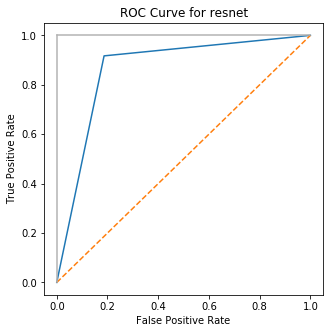

,Accuracy,Precision,Recall,F1,ROC
0,0.820018,0.250246,0.916968,0.393189,0.865201


In [42]:
GetMetrics(resnet, image_over_test, label_over_test, 'resnet')

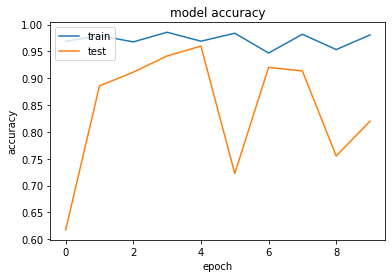

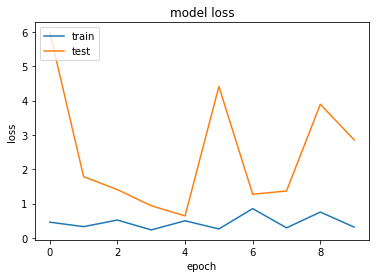

In [43]:
plothistory(history)

In [47]:
def getResNet2():
    model = Sequential()
    model.add(restnet)
    model.add(Dense(512, activation='relu', input_dim = (200, 200, 3)))
    model.add(Dropout(0.4))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [48]:
resnet2 = getResNet2()
resnet2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 100352)            23587712  
_________________________________________________________________
dense_7 (Dense)              (None, 512)               51380736  
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 513       
Total params: 75,231,617
Trainable params: 51,643,905
Non-trainable params: 23,587,712
_______________________________________________________

In [49]:
history = resnet2.fit(image_over_train, label_over_train, validation_data=(image_over_test, label_over_test), epochs=10, batch_size = 128)

Train on 28300 samples, validate on 4356 samples
Epoch 1/10
28300/28300 [==============================] - 2218s 78ms/step - loss: 0.4882 - acc: 0.9663 - val_loss: 2.9314 - val_acc: 0.8131
Epoch 2/10
28300/28300 [==============================] - 2107s 74ms/step - loss: 0.5079 - acc: 0.9681 - val_loss: 1.6664 - val_acc: 0.8937
Epoch 3/10
28300/28300 [==============================] - 2158s 76ms/step - loss: 0.6775 - acc: 0.9575 - val_loss: 5.0518 - val_acc: 0.6816
Epoch 4/10
28300/28300 [==============================] - 2054s 73ms/step - loss: 0.4394 - acc: 0.9725 - val_loss: 0.3246 - val_acc: 0.9798
Epoch 5/10
28300/28300 [==============================] - 2076s 73ms/step - loss: 0.6556 - acc: 0.9588 - val_loss: 1.5483 - val_acc: 0.9027
Epoch 6/10
28300/28300 [==============================] - 2000s 71ms/step - loss: 0.4994 - acc: 0.9689 - val_loss: 3.2275 - val_acc: 0.7973
Epoch 7/10
28300/28300 [==============================] - 2002s 71ms/step - loss: 0.3791 - acc: 0.9764 - val_lo

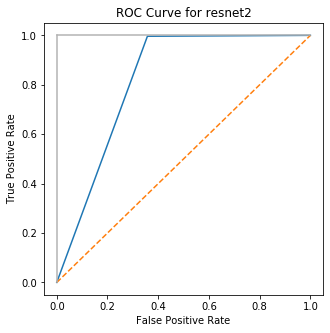

,Accuracy,Precision,Recall,F1,ROC
0,0.66506,0.15917,0.99639,0.27449,0.819475


In [50]:
GetMetrics(resnet2, image_over_test, label_over_test, 'resnet2')

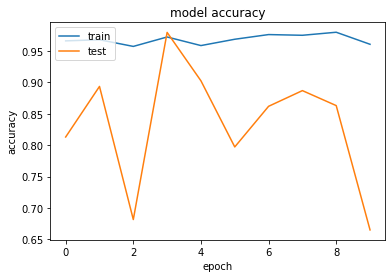

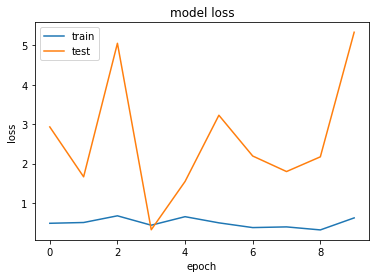

In [51]:
plothistory(history)